In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
import missingno as msno
import scipy.stats as stats
import pylab
from IPython import display
import warnings
plt.style.use('ggplot')
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
%matplotlib inline

- The following example demonstrates the Python code that loads the data as a Pandas DataFrame, which is a tabular data structure that allows for simple arithmetic operations and grouping. To facilitate data manipulation, the special ID column will be used as the DataFrame index. Setting the 'index col' parameter to the name of the index column accomplishes this.

In [2]:
data=pd.read_csv('preprocessed_data.csv')

In [3]:
# data=data.drop('Unnamed: 0',axis=1)
data=data.replace(' NULL',np.nan)

In [4]:
for col in ['PS_Above_PEEP','EPAP_PEEP', 'SET_FIO2', 'Spont_RR', 'Deadspace', 'SBI', 'P01', 'PH',
            'PaCO2', 'PaO2', 'LactateABG', 'HeartRate', 'ArtSystollic', 'ArtMAP','Temperature']:
    data[col] = data[col].astype('float64')

In [5]:
dataNaN=data.set_index('ID')

In [6]:
dataNaN.head()

,Time,AdmissionDate,DischargeDate,CCOutcome,HospOutcome,VentMode,PS_Above_PEEP,EPAP_PEEP,SET_FIO2,Spont_RR,Deadspace,SBI,P01,PH,PaCO2,PaO2,LactateABG,HeartRate,ArtSystollic,ArtMAP,Temperature,TIMEDELTA
ID,,,,,,,,,,,,,,,,,,,,,,
45056,19:23:00,20/07/2140 19:18,06/10/2140 08:42,A,A,PRVC,NaN,5.0,50.0,23.0,13.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0
45056,19:24:00,20/07/2140 19:18,06/10/2140 08:42,A,A,PRVC,NaN,5.0,50.0,0.0,14.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0
45056,19:25:00,20/07/2140 19:18,06/10/2140 08:42,A,A,PRVC,NaN,5.0,50.0,0.0,14.6,NaN,NaN,NaN,NaN,NaN,NaN,85.0,NaN,NaN,NaN,19.0
45056,19:26:00,20/07/2140 19:18,06/10/2140 08:42,A,A,PRVC,NaN,5.0,50.0,0.0,14.7,NaN,NaN,NaN,NaN,NaN,NaN,82.0,NaN,NaN,NaN,19.0
45056,19:27:00,20/07/2140 19:18,06/10/2140 08:42,A,A,PRVC,NaN,5.0,50.0,0.0,14.8,NaN,NaN,NaN,NaN,NaN,NaN,82.0,NaN,NaN,NaN,19.0


It tells us that the dataset contains information regarding patient physiological vital signs:PS_Above_PEEP,EPAP_PEEP,SET_FIO2,Spont_RR,DeadSpace,PaCO2,PaO2,SBI,P01; lab tests:pH. Each observation/row is associated with a time stamp (column 'TIMEDELTA'), indicating the number of hours since ICU admission where the observation was made. Each icustay(ID) has several observations for the same variable/column.

We can print the number of ICU stays(ID) by calculating the length of the unique indexes, number of missing data using the 'info' function and summary statistics using the 'describe' function:

In [7]:
dataNaN.CCOutcome[dataNaN.CCOutcome==' A']=0
dataNaN.CCOutcome[dataNaN.CCOutcome==' D']=1

In [8]:
dataNaN['CCOutcome']=dataNaN['CCOutcome'].astype(int)

In [9]:
print('Number of ICU stays: ' + str(len(dataNaN.index.unique())))
print('Number of survivors: ' + str(len(dataNaN[dataNaN['CCOutcome']==0].index.unique())))
print('Number of non-survivors: ' + str(len(dataNaN[dataNaN['CCOutcome']==1].index.unique())))
print('Mortality: ' + str(round(100*len(dataNaN[dataNaN['CCOutcome']==1].index.unique()) / len(dataNaN.index.unique()),1)) + '%')
print()
display.display(dataNaN.info(null_counts=1))
display.display(dataNaN.describe())

Number of ICU stays: 97
Number of survivors: 74
Number of non-survivors: 23
Mortality: 23.7%

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 45056 to 47502
Data columns (total 22 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Time           1048575 non-null  object 
 1   AdmissionDate  1048575 non-null  object 
 2   DischargeDate  1048575 non-null  object 
 3   CCOutcome      1048575 non-null  int32  
 4   HospOutcome    799430 non-null   object 
 5   VentMode       1048575 non-null  object 
 6   PS_Above_PEEP  659608 non-null   float64
 7   EPAP_PEEP      1048466 non-null  float64
 8   SET_FIO2       1046527 non-null  float64
 9   Spont_RR       1045294 non-null  float64
 10  Deadspace      1047188 non-null  float64
 11  SBI            702194 non-null   float64
 12  P01            773384 non-null   float64
 13  PH             5329 non-null     float64
 14  PaCO2          5351 non-null     float64
 15  PaO2

None

,CCOutcome,PS_Above_PEEP,EPAP_PEEP,SET_FIO2,Spont_RR,Deadspace,SBI,P01,PH,PaCO2,PaO2,LactateABG,HeartRate,ArtSystollic,ArtMAP,Temperature,TIMEDELTA
count,1.048575e+06,659608.000000,1.048466e+06,1.046527e+06,1.045294e+06,1.047188e+06,702194.000000,773384.000000,5329.000000,5351.000000,5309.000000,5341.000000,1.011677e+06,875634.000000,880870.000000,50764.000000,1.048575e+06
mean,1.919538e-01,7.696079,7.879490e+00,3.851507e+01,1.629772e+01,1.861215e+01,75.733478,1.850328,7.412141,5.518107,12.341496,1.365059,8.588252e+01,127.390978,83.294622,37.473300,1.148236e+01
std,3.938372e-01,4.786168,2.515971e+00,1.254380e+01,1.251101e+01,5.699877e+00,231.746078,1.840525,0.086883,1.311227,4.037776,1.324051,2.000795e+01,24.321505,14.755915,0.925905,6.993432e+00
min,0.000000e+00,0.000000,0.000000e+00,2.100000e+01,0.000000e+00,0.000000e+00,2.000000,-1.000000,6.904000,2.780000,3.540000,0.300000,1.200000e+01,10.000000,10.000000,11.600000,0.000000e+00
25%,0.000000e+00,5.000000,5.000000e+00,3.000000e+01,0.000000e+00,1.450000e+01,34.000000,0.600000,7.378000,4.680000,10.270000,0.820000,7.100000e+01,110.000000,73.000000,37.100000,5.000000e+00
50%,0.000000e+00,8.000000,8.000000e+00,3.500000e+01,1.770000e+01,1.810000e+01,51.000000,1.300000,7.430000,5.330000,11.740000,1.070000,8.400000e+01,125.000000,81.000000,37.500000,1.100000e+01
75%,0.000000e+00,10.000000,1.000000e+01,4.500000e+01,2.530000e+01,2.260000e+01,77.000000,2.500000,7.471000,6.080000,13.550000,1.400000,9.900000e+01,142.000000,91.000000,37.900000,1.800000e+01
max,1.000000e+00,28.100000,3.000000e+01,1.000000e+02,2.410000e+02,5.200000e+01,9970.000000,47.600000,7.613000,16.800000,81.400000,20.000000,3.000000e+02,349.000000,200.000000,40.600000,2.300000e+01


The dataset consists of 97 unique ICU stays and 1,048,575  observations. All columns with the exception of 'TIMEDELTA', 'CCOutcome','VentMode' have missing information. Looking at the maximum and minimum values it is possible to spot the presence of outliers. Both missing data and outliers are very common in ICU databases and need to be taken into consideration before applying ML algorithms.

#### Variable selection
There should be a trade-off between the potential value of the variable in the model and the amount of data available. We already saw the amount of missing data for every column, but we still do not know how much information is missing at the patient level. In order to do so, we are going to aggregate data by ID and look at the number of non-null values, using the 'groupby' function together with the 'mean' operator. This will give an indication of how many ICU stays have at least one observation for each variable.

Note that one patient might have multiple ICU stays(ID). In this work, for the sake of simplicity, we will consider every ICU stay(ID) as an independent sample

In [10]:
print(dataNaN.groupby(['ID']).mean().info(null_counts=1))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 45056 to 47502
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CCOutcome      97 non-null     int32  
 1   PS_Above_PEEP  84 non-null     float64
 2   EPAP_PEEP      97 non-null     float64
 3   SET_FIO2       97 non-null     float64
 4   Spont_RR       97 non-null     float64
 5   Deadspace      97 non-null     float64
 6   SBI            88 non-null     float64
 7   P01            97 non-null     float64
 8   PH             97 non-null     float64
 9   PaCO2          97 non-null     float64
 10  PaO2           97 non-null     float64
 11  LactateABG     97 non-null     float64
 12  HeartRate      97 non-null     float64
 13  ArtSystollic   96 non-null     float64
 14  ArtMAP         96 non-null     float64
 15  Temperature    96 non-null     float64
 16  TIMEDELTA      97 non-null     float64
dtypes: float64(16), int32(1)
memory usage: 13.3 KB
No

In [11]:
variables=['PS_Above_PEEP', 'EPAP_PEEP', 'SET_FIO2', 'P01', 'PH','PaCO2','PaO2',
       'LactateABG', 'HeartRate','Temperature']
variables_mort = variables.copy()
variables_mort.append('CCOutcome')

### Data visualization
#### Outliers
We already saw that outliers exist in the dataset, but we need to look at the data more closely before determining how to treat them. We can easily generate one boxplot for each vector by using the'seaborn' library and the 'boxplot' feature. Seaborn is a matplotlib-based visualisation library that offers a high-level interface for drawing statistical graphics.

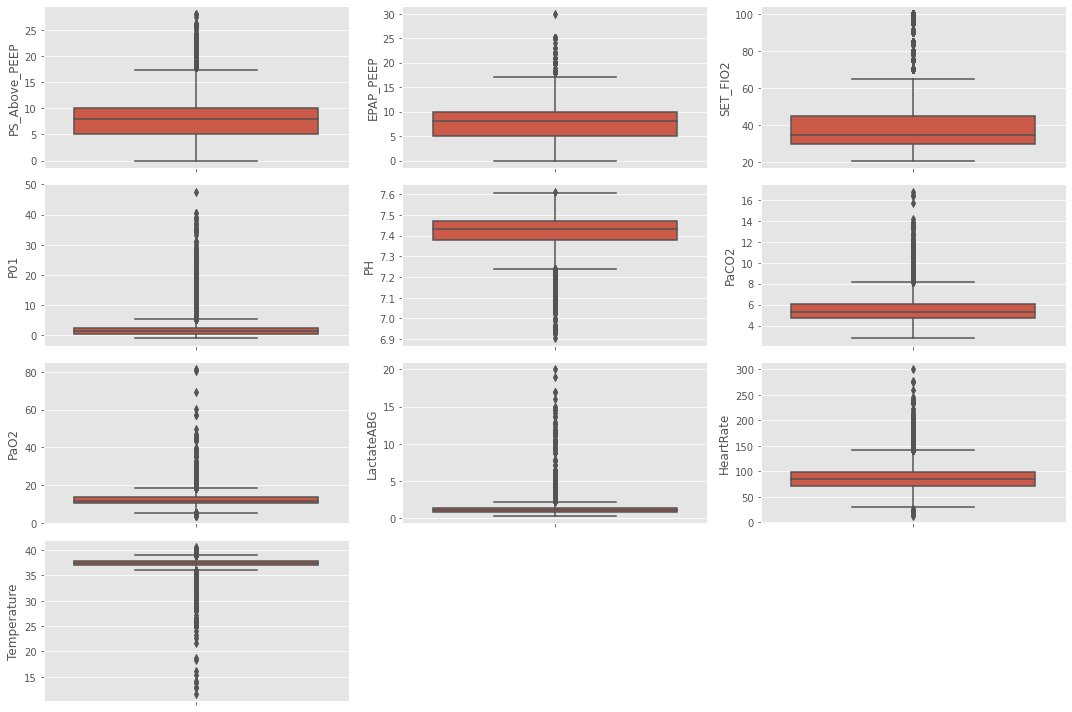

In [12]:
import seaborn as sns

fig = plt.figure(figsize=(15,10))
count = 0
for variable in variables:
    count += 1
    plt.subplot(4, 3, count)    
    ax = sns.boxplot(y=variable, data=dataNaN)
    
fig.tight_layout()
plt.show()

In certain cases, the outliers are so far from the average that using boxplots to visualise the data distribution (minimum, first quartile, median, third quartile, maximum) is impossible. Other plot styles may be used to explore the existence of outliers. Some alternatives include simply plotting all points using a scatter plot or using violin plots.

#### Exclusion
Ideally, we should keep extreme values related to the patients' poor health condition and exclude impossible values (such as negative temperature) and probable outliers (such as heart rate above 100). In order to do so, values that fall outside boundaries defined by expert knowledge are excluded. This way, we avoid excluding extreme (but correct/possible) values.

In [13]:
nulls_before = dataNaN.isnull().sum().sum()

dataNaN.loc[dataNaN['PS_Above_PEEP']>5,'PS_Above_PEEP']=np.nan
dataNaN.loc[dataNaN['EPAP_PEEP']<5,'EPAP_PEEP']=np.nan
dataNaN.loc[dataNaN['P01']<3,'P01']=np.nan
dataNaN.loc[dataNaN['SET_FIO2']<20, 'SET_FIO2'] = np.nan
dataNaN.loc[dataNaN['LactateABG']<2, 'LactateABG'] = np.nan
dataNaN.loc[dataNaN['PH']>7.8, 'PH'] = np.nan
dataNaN.loc[dataNaN['PH']<6.8, 'PH'] = np.nan
dataNaN.loc[dataNaN['HeartRate']>100, 'HeartRate'] = np.nan
dataNaN.loc[dataNaN['Temperature']>=38, 'Temperature'] = np.nan

nulls_now = dataNaN.isnull().sum().sum()
print('Number of observations removed: ' + str(nulls_now - nulls_before))
print('Observations corresponding to outliers: ' + str(round((nulls_now - nulls_before)*100/dataNaN.shape[0],2)) + '%')

Number of observations removed: 1339403
Observations corresponding to outliers: 127.74%


#### Data visualization after outliers exclusion
The same code will be used to validate the data distribution after outliers have been removed. The'stripplot' function visualises the underlying distribution as well as the number of observations. When x = 'CCOutcome,' the boxplots are partitioned by result.

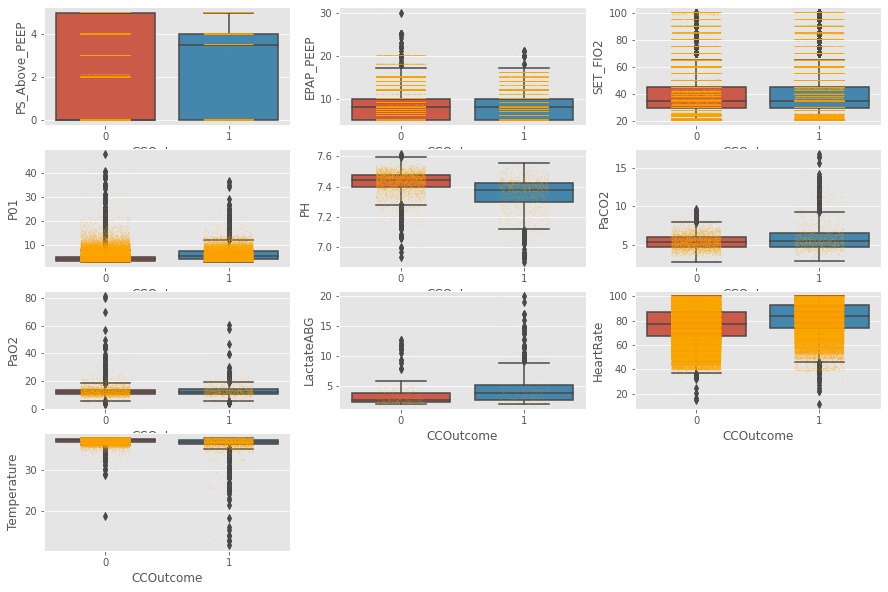

In [14]:
fig = plt.figure(figsize=(15,10))
count = 0
for variable in variables:
    count += 1
    plt.subplot(4, 3, count)
    
    #ax = sns.boxplot(y=variable, data=data)
    #ax = sns.stripplot(y=variable, data=data, color="orange", jitter=0.2, size=0.5)
    
    # same but partitioned by outcome
    ax = sns.boxplot(x = 'CCOutcome', y=variable, data=dataNaN)
    ax = sns.stripplot(x = 'CCOutcome', y=variable, data=dataNaN, color="orange", jitter=0.2, size=0.5)

# fig.tight_layout()
plt.show()

#### Aggregate data by hour

As previously said, the dataset includes details about the first two days in the ICU. Any observation has a time stamp that indicates the number of hours between ICU entry and the time the observation was obtained (e.g., 0.63 hours).Person data is distilled into hourly observations for ease of analysis by choosing the median value of the available observations within each hour. First, the 'floor' operator is used to divide the hours into 48 bins. The 'groupby' function is then used with the'median' operator to obtain the median heart rate for each hour of each ICU stay(ID).

In [15]:
# data goes until h = 48, change 48 to 47
dataNaN.loc[dataNaN['TIMEDELTA'] == 48, 'TIMEDELTA']=47
 
data_median_hour = dataNaN.groupby(['ID','TIMEDELTA'])[variables_mort].mean()

In [16]:
data_median_hour = data_median_hour.reset_index(level=(1),drop=False)

The next example shows the vital signs for a specific ICU stay (ID = 45056). Consecutive hourly observations are connected by line.

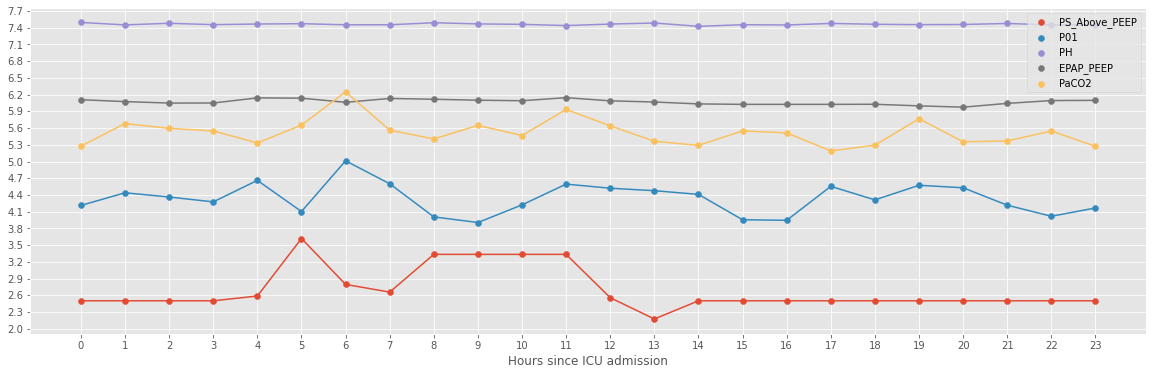

In [17]:
vitals =['PS_Above_PEEP','P01','PH','EPAP_PEEP','PaCO2']
ICUstayID = 45056

fig, ax = plt.subplots(figsize=(20,6))


# scatter plot
for col in vitals:
    ax.scatter(data_median_hour.loc[ICUstayID,'TIMEDELTA'], data_median_hour.loc[ICUstayID,col])
    ax.legend(vitals)
    plt.yticks(np.arange(2,8,step=0.3))
    plt.xticks(np.arange(0, 24))
    plt.xlabel('Hours since ICU admission')
    
# connect consecutive points by line
for col in vitals:    
    ax.plot(data_median_hour.loc[ICUstayID,'TIMEDELTA'], data_median_hour.loc[ICUstayID,col])

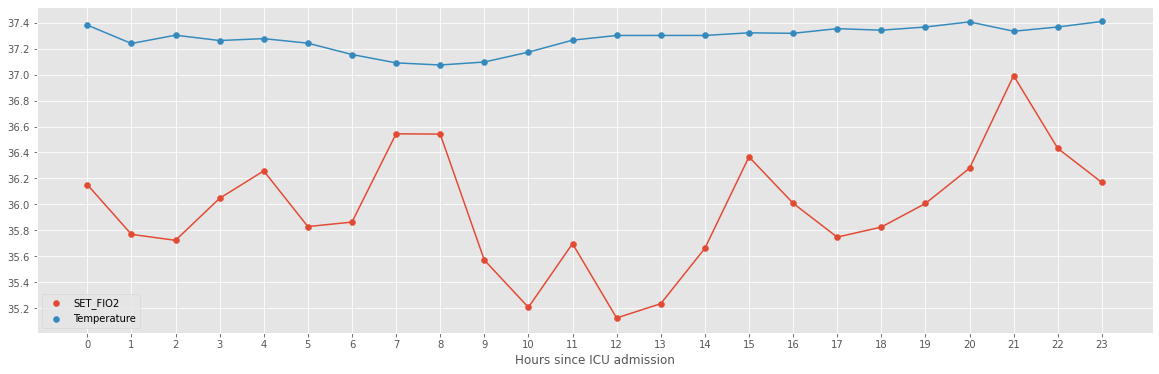

In [19]:
vitals =['SET_FIO2','Temperature']
ID = 45056

fig, ax = plt.subplots(figsize=(20,6))


# scatter plot
for col in vitals:
    ax.scatter(data_median_hour.loc[ID,'TIMEDELTA'], data_median_hour.loc[ID,col])
    ax.legend(vitals)
    plt.yticks(np.arange(30,40,step=0.2))
    plt.xticks(np.arange(0, 24))
    plt.xlabel('Hours since ICU admission')
    
# connect consecutive points by line
for col in vitals:    
    ax.plot(data_median_hour.loc[ID,'TIMEDELTA'], data_median_hour.loc[ID,col])

#### Select minimum number of observations
We made the decision to leave all time-varying variables open. However, as seen in the preceding case, since not all variables have an hourly sampling rate, a lot of information is lost (coded as NaN). It is essential to determine how to treat missed information before training ML algorithms.There are two options: substitute the missing information with something valuable or exclude the missing information. We can prevent adding bias in this work by replacing missing values with expected values (which is not the same as saying that this is not a good option in some situations). Instead, we will concentrate on a comprehensive case study.

Complete knowledge may have different interpretations depending on how we construct the feature collection. For eg, if we want to use one observation per hour, full information means no missed data from t=0 to t=23, which will result in the omission of the majority of data. One typical method for reducing the size of the function space is to use only a portion of the time series. This is the approach that will be used in this project. To derive useful information from the time series, summary statistics such as the mean, limit, minimum, and standard deviation would be used. It is critical in this case to determine the minimum duration of the time series before beginning to pick portions of it. One solution will be to include all patients who have at least one observation about each component. Since summary figures have no significance if only one observation is visible, a two-observation threshold would be used.

Setting'min num meas = 4' means we're looking for ICU stays (ID) where each vector was registered at least once at four different times. Again, we're aggregating data by ICU stay(ID) and counting the number of observations for each vector with the 'groupby' function. Then, we omitted ICU stays (ID) in which any variable was registered less than twice.

In [20]:
min_num_meas = 4

def extr_min_num_meas(data_median_hour, min_num_meas):
    """ Select ICU stays where there are at least 'min_num_meas' observations 
    and print the resulting DataFrame size"""
    data_count = data_median_hour.groupby(['ID'])[variables_mort].count()

    for col in data_count:
        data_count[col] = data_count[col].apply(lambda x: np.nan if x < min_num_meas else x)

    data_count = data_count.dropna(axis=0, how='any')
    print('Number of ICU stays: ' + str(data_count.shape[0]))
    print('Number of features: ' + str(data_count.shape[1]))
    unique_stays = data_count.index.unique()

    data_median_hour = data_median_hour.loc[unique_stays]
    
    return data_median_hour

data_median_hour = extr_min_num_meas(data_median_hour, min_num_meas)

Number of ICU stays: 19
Number of features: 11


#### Pairwise ploting
The pairs plot is a common technique in exploratory data analysis (also called scatterplot). This approach helps you to see the distribution of individual variables as well as the relationships between each pair of variables. It is simple to implement in Python with the'seaborn' library. The following example demonstrates how to map pairwise relationships between variables as well as histograms of single variables partitioned by result (Alive vs Dead). The parameter 'vars' specifies the collection of variables to plot, and the parameter 'hue' specifies the use of separate markers for each stage of the hue variable.

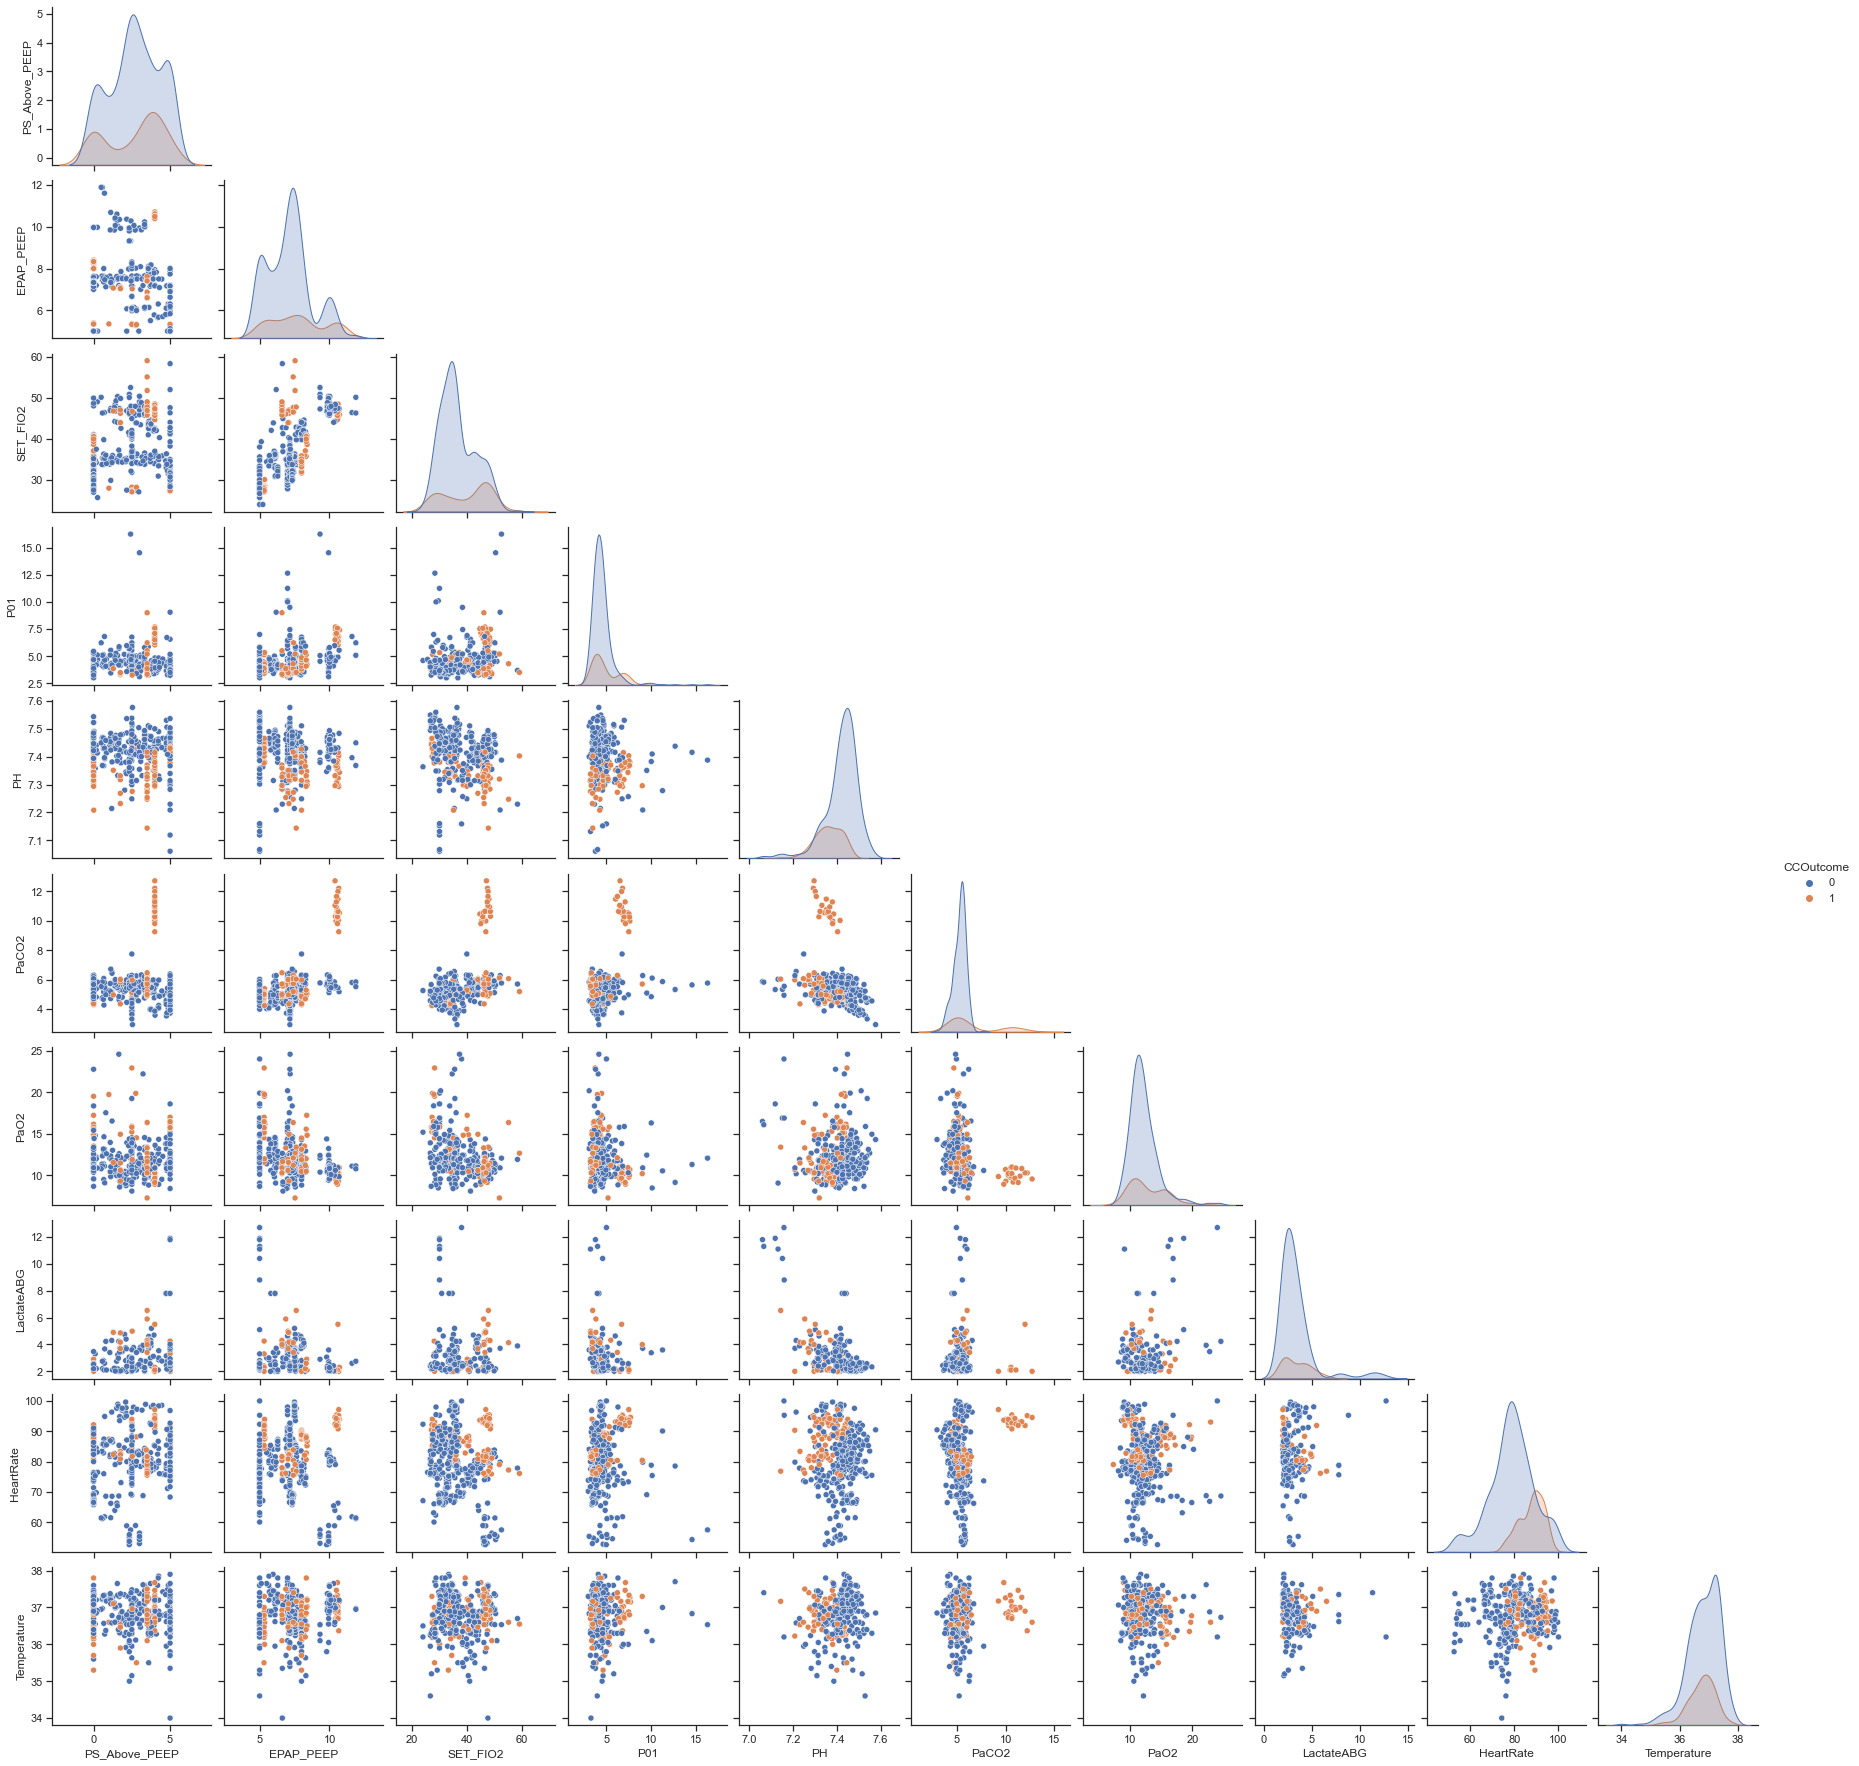

In [21]:
import seaborn as sns

sns.set(style="ticks")
g = sns.pairplot(data_median_hour[variables_mort], vars = variables, hue = 'CCOutcome')

# hide the upper triangle
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
plt.show()

# change back to our preferred style
plt.style.use('ggplot')

#### Time series ploting
It is useful to visualise the mean HR partitioned by result from t=0 to t=23 in order to investigate time patterns. The DataFrame must be restructured in order to execute this process easily.

The following function takes a pandas DataFrame and the variable name as input and transposes/pivots the DataFrame to have columns corresponding to time and rows corresponding to ICU stays.If 'filldata' is set to 1, the feature will use the forward fill method to fill missing information, replacing NaNs with the value preceding it. NaNs are replaced by the next value in the time series if no value is sufficient for forward fill.We can conveniently execute these two acts by using the function 'fillna' with the method parameter set to 'ffill' and 'bfill'. When 'filldata' is set to 0, no missing data imputation occurs.

In [22]:
def timeseries_data(data_median_hour, variable, filldata = 1):
    """Return matrix of time series data for clustering,
    with rows corresponding to unique observations (ICU stays) and 
    columns corresponding to time since ICU admission"""
    data4clustering = data_median_hour.pivot(columns='TIMEDELTA', values=variable)
    if filldata == 1:
        # first forward fill
        data4clustering = data4clustering.fillna(method='ffill', axis=1)
        # next backward fill
        data4clustering = data4clustering.fillna(method='bfill', axis=1)
        data4clustering = data4clustering.dropna(axis=0, how='all')
    return data4clustering

Plotting 377 observations from 19 ICU stays - PS_Above_PEEP
Plotting 455 observations from 19 ICU stays - EPAP_PEEP
Plotting 455 observations from 19 ICU stays - SET_FIO2
Plotting 412 observations from 19 ICU stays - P01
Plotting 396 observations from 19 ICU stays - PH
Plotting 396 observations from 19 ICU stays - PaCO2
Plotting 395 observations from 19 ICU stays - PaO2
Plotting 187 observations from 19 ICU stays - LactateABG
Plotting 449 observations from 19 ICU stays - HeartRate
Plotting 396 observations from 19 ICU stays - Temperature


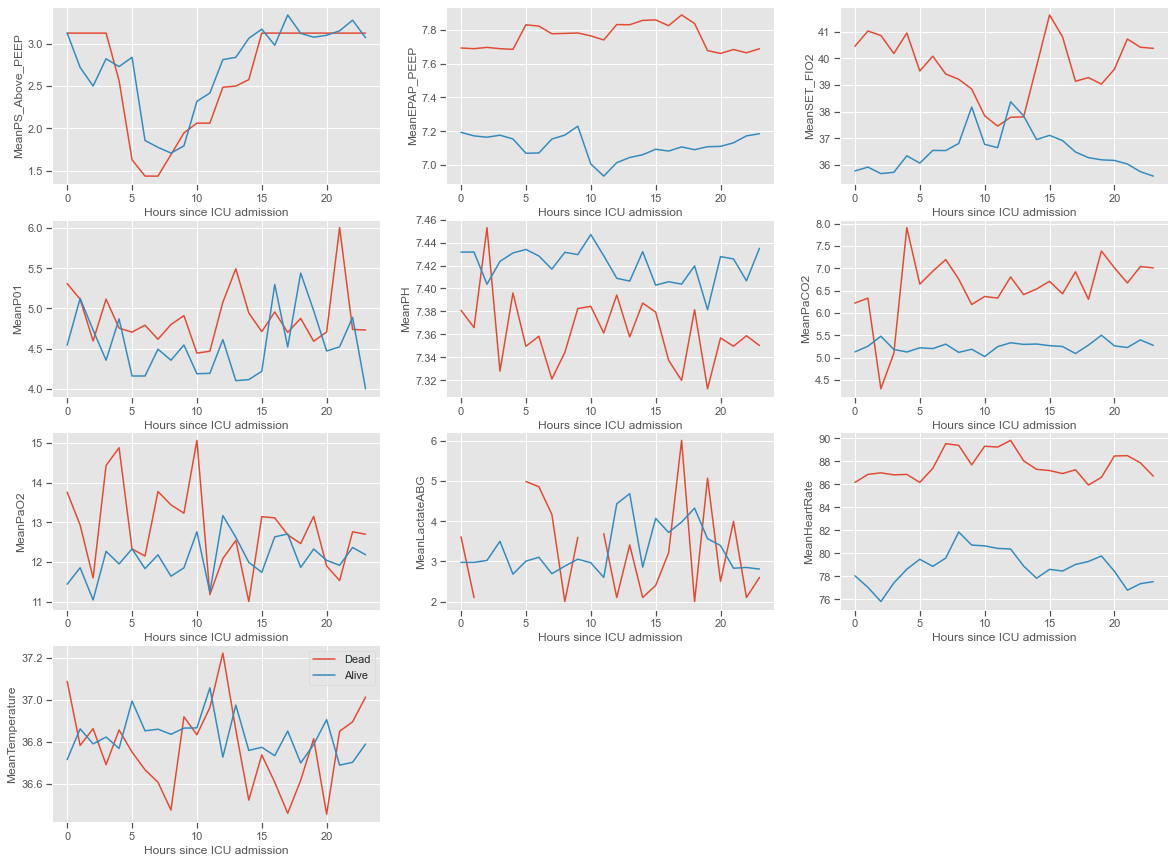

In [23]:
fig = plt.figure(figsize=(20,15))
count = 0
for variable in variables:
    count += 1
    data4clustering = timeseries_data(data_median_hour, variable, filldata = 0)
    print('Plotting ' + str(data4clustering.count().sum()) + ' observations from ' + str(data4clustering.shape[0]) + ' ICU stays' + ' - ' + variable)    
    class1 = data4clustering.loc[data_median_hour[data_median_hour['CCOutcome']==1].index].mean()
    class0 = data4clustering.loc[data_median_hour[data_median_hour['CCOutcome']==0].index].mean()
    plt.subplot(4, 3,count)
    plt.plot(class1)
    plt.plot(class0)
    plt.xlabel('Hours since ICU admission')
    plt.ylabel('Mean'+variable)

plt.legend(['Dead', 'Alive'])    
plt.show()

Physiological decline or recovery over time differs greatly between survivors and non-survivors. We couldn't see any distinctions between the groups when we used the pairwise plot, but this sort of plot shows very strong differences. Several findings are possible:Feature construction
__P01:__
- higher in the dead group
- rapidly decreasing during the first 5 hours.

__SET_FIO2:__
- higher in the dead group, increasing over time
- different between both groups at admission,and converging at one point but diverging thereafter

__Heart rate:__
- lower in the alive group

__Temperature:__
- low variation from t=0 to t=23h
- slightly increasing during the first 10 hours

__PH:__
- Increasing over time in both groups
- pH < 7.35 from t=4 to t=23h in the dead group

#### Feature construction
The dilemma of finding the transformation of variables that contains the most valuable details is addressed by feature construction. Easy operations will be used in this project to construct/extract essential features from time series:

- Maximum
- Minimum
- Standard deviation
- Mean

From t=0 to t=23h, these characteristics summarise the worst, greatest, difference, and normal patient's status. In the suggested exercises, you will do this for each day individually, which will maximise the dimensionality of the dataset but, ideally, allow for the retrieval of more valuable information.

These features can be conveniently extracted by using the 'groupby' function to combine data by ICU stay(ID), along with the'max','min','std', and'mean' operators:

In [24]:
def feat_transf(data):
    data_max = data.groupby(['ID'])[variables].max()
    data_max.columns = ['max ' + str(col) for col in data_max.columns]

    data_min = data.groupby(['ID'])[variables].min()
    data_min.columns = ['min ' + str(col) for col in data_min.columns]
    
    data_sd = data.groupby(['ID'])[variables].std()
    data_sd.columns = ['sd ' + str(col) for col in data_sd.columns]

    data_mean = data.groupby(['ID'])[variables].mean()
    data_mean.columns = ['mean ' + str(col) for col in data_mean.columns]

    data_agg = pd.concat([data_min,data_max,data_sd,data_mean],axis=1)
    
    return data_agg

data_transf = feat_transf(data_median_hour).dropna(axis=0)

print('Extracted features: ')
display.display(data_transf.columns)
print('')
print('Number of ICU stays: ' + str(data_transf.shape[0]))
print('Number of features: ' + str(data_transf.shape[1]))

Extracted features: 


Index(['min PS_Above_PEEP', 'min EPAP_PEEP', 'min SET_FIO2', 'min P01',
       'min PH', 'min PaCO2', 'min PaO2', 'min LactateABG', 'min HeartRate',
       'min Temperature', 'max PS_Above_PEEP', 'max EPAP_PEEP', 'max SET_FIO2',
       'max P01', 'max PH', 'max PaCO2', 'max PaO2', 'max LactateABG',
       'max HeartRate', 'max Temperature', 'sd PS_Above_PEEP', 'sd EPAP_PEEP',
       'sd SET_FIO2', 'sd P01', 'sd PH', 'sd PaCO2', 'sd PaO2',
       'sd LactateABG', 'sd HeartRate', 'sd Temperature', 'mean PS_Above_PEEP',
       'mean EPAP_PEEP', 'mean SET_FIO2', 'mean P01', 'mean PH', 'mean PaCO2',
       'mean PaO2', 'mean LactateABG', 'mean HeartRate', 'mean Temperature'],
      dtype='object')


Number of ICU stays: 19
Number of features: 40


In [25]:
mortality = dataNaN.loc[data_transf.index]['CCOutcome'].groupby(['ID']).mean()
data_transf_inv = pd.concat([data_transf,mortality], axis=1)
print('Number of ICU stays: ' + str(data_transf_inv.shape[0]))
print('Number of features: ' + str(data_transf_inv.shape[1]))

Number of ICU stays: 19
Number of features: 41


#### Data partitioning
In order to assess the performance of the models, data can be divided into training, test and validation sets.
- The training set is what is used to train/build the learning algorithm.
- Validation (or development) set: used to tune parameters, pick functions, and make other learning algorithm decisions.
- Test set: used to measure the algorithm's output but not to make any assumptions about the learning algorithm design or parameters.

Scikit-learn is Python's basic machine learning bundle. It offers easy and effective data processing and data analysis methods. The following example demonstrates how to use the 'train test split' function from the'sklearn' library to assign observations to each collection at random. The 'test size' parameter, which specifies the size of the test set and is set to 30% in this case, can be used to control the size of the sets. It is important to set the 'random state' parameter by using the 'train test split' function so that the same effects can be repeated later.

In [26]:
from sklearn.model_selection import train_test_split

# set the % of observations in the test set
test_size = 0.3

# Divide the data intro training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_transf_inv, data_transf_inv[['CCOutcome']], test_size = test_size, random_state = 1234)

In [27]:
def print_size(y_train, y_test):
    print(str(len(y_train[y_train['CCOutcome']==1])) + '(' + str(round(len(y_train[y_train['CCOutcome']==1])/len(y_train)*100,1)) + '%)' + ' dead in training set')
    print(str(len(y_train[y_train['CCOutcome']==0])) + '(' + str(round(len(y_train[y_train['CCOutcome']==0])/len(y_train)*100,1)) + '%)' + ' alive in training set')
    print(str(len(y_test[y_test['CCOutcome']==1])) + '(' + str(round(len(y_test[y_test['CCOutcome']==1])/len(y_test)*100,1)) + '%)' + ' dead in test set')
    print(str(len(y_test[y_test['CCOutcome']==0])) + '(' + str(round(len(y_test[y_test['CCOutcome']==0])/len(y_test)*100,1)) + '%)' + ' alive in test set')

In situations where the data is heavily imbalanced, forcing an oversampling of the minority class or an undersampling of the majority class may be a safe solution to ensure that the model is not skewed against the majority class. This should be done on the training set, while the test set should retain the class imbalance discovered on the original data, so that when testing the final model, a true representation of the data is used.

Undersampling is used to improve the interpretability of clustering. However, as a general rule, and whether the dataset includes a large amount of observations, oversampling is favoured over undersampling because it requires all of the information in the training set to be retained. In any case, using learning algorithms that take into account class imbalance might be a safer option.

The following example demonstrates how to undersample the majority class given a desired size of the minority class, which is governed by the parameter 'perc class1'. If 'perc class1' is greater than zero, undersampling is used to create a balanced training package. If 'perc class1' is set to 0, no balancing is done.

In [28]:
# set the % of class 1 samples to be present in the training set. 
perc_class1 = 0.4

print('Before balancing')
print_size(y_train, y_test)
        
if perc_class1 > 0:
        
    # Find the indices of class 0 and class 1 samples
    class0_indices = y_train[y_train['CCOutcome'] == 0].index
    class1_indices = y_train[y_train['CCOutcome'] == 1].index

    # Calculate the number of samples for the majority class (survivors)
    class0_size = round(np.int((len(y_train[y_train['CCOutcome'] == 1])*(1 - perc_class1)) / perc_class1),0)
    
    # Set the random seed generator for reproducibility
    np.random.seed(10)
        
    # Random sample majority class indices
    random_indices = np.random.choice(class0_indices, class0_size)    
        
    # Concat class 0 with class 1 indices
    X_train = pd.concat([X_train.loc[random_indices],X_train.loc[class1_indices]])
    y_train = pd.concat([y_train.loc[random_indices],y_train.loc[class1_indices]])

    print('After balancing')
    print_size(y_train, y_test)
            
# Exclude output from input data
X_train = X_train.drop(columns = 'CCOutcome')
X_test = X_test.drop(columns = 'CCOutcome')

Before balancing
3(23.1%) dead in training set
10(76.9%) alive in training set
1(16.7%) dead in test set
5(83.3%) alive in test set
After balancing
3(42.9%) dead in training set
4(57.1%) alive in training set
1(16.7%) dead in test set
5(83.3%) alive in test set


#### Clustering
Clustering is a learning task that attempts to divide a given collection of observations into subgroups (clusters) based on data similarities, so that observations in the same cluster are more closely related to one another than observations in different clusters. It is an unsupervised learning task because it detects structures in unlabeled datasets, and a classification task because it can classify findings based on the cluster to which they are assigned.

This work is concerned with the following issues:

- Will we distinguish distinct trends in the absence of class labels?

- How are the various trends expressed through various outcomes?

To answer these questions, we will first provide a summary of the fundamental principles underlying k-means clustering, the most well-known and straightforward clustering algorithm. We will demonstrate how the algorithm operates by using 2D data as an example, perform time series clustering, and use the knowledge obtained from clustering to train predictive models.

#### Exemplification with 2D data
While pairwise plots revealed no interesting trends, some clusters may have appeared after the data was transformed. You can re-run the code for pairwise plots between transformed features, but due to the high dimensionality of the dataset, this would be time consuming. For illustration purposes, the features'max PH' and'mean PaCO2' were selected.

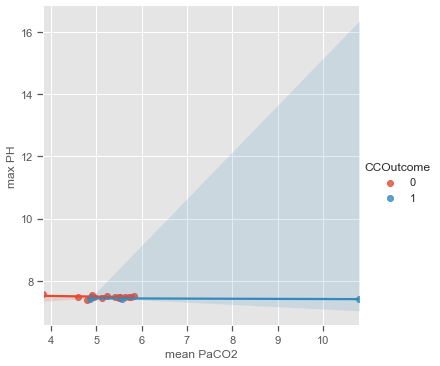

In [29]:
x1 = 'max PH'
x2 = 'mean PaCO2'
sns.lmplot(x2, x1,data_transf_inv, hue="CCOutcome");

In [30]:
from sklearn.cluster import KMeans

# set the number of clusters
K = 3
# input data to fit K-means
X = data_transf_inv[[x1,x2]].values

# fit kmeans
kmeans = KMeans(n_clusters=K, random_state=0).fit(data_transf_inv[[x1,x2]])

The attribute 'labels_' contains the cluster labels that indicate which cluster each observation belongs to, and the attribute 'clustercenters' contains the coordinates of cluster centres that represent the mean of all observations in the cluster. It is possible to map the clusters' centres and data in each cluster using various colours to differentiate the clusters using these two attributes:

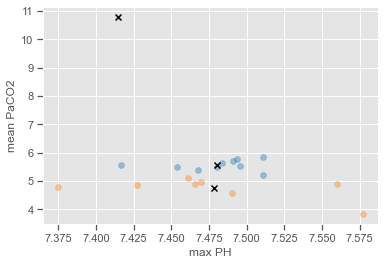

In [31]:
classes = kmeans.labels_
centroids = kmeans.cluster_centers_

# define a colormap
colormap = plt.get_cmap('tab20')
for c in range(K):
    centroids[c] = np.mean(X[classes == c], 0)
    plt.scatter(x = X[classes == c,0], y = X[classes == c,1], alpha = 0.4, c = colormap(c))
    plt.scatter(x = centroids[c,0], y = centroids[c,1], c = 'black', marker='x')
        
plt.xlabel(x1)
plt.ylabel(x2)
display.clear_output(wait=True)

The algorithm is simple enough that it can be applied with only a few lines of code. If you want to see how the centres converge after many iterations, you can use the code below, which is a step-by-step implementation of the k-means clustering algorithm.

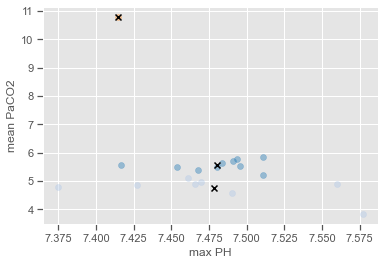

<Figure size 432x288 with 0 Axes>

In [32]:
import time
from IPython import display

K = 3

def initialize_clusters(points, k):
    """Initializes clusters as k randomly selected coordinates."""
    return points[np.random.randint(points.shape[0], size=k)]
    
def get_distances(centroid, points):
    """Returns the distance between centroids and observations."""
    return np.linalg.norm(points - centroid, axis=1)

# Initialize centroids
centroids = initialize_clusters(X, K)
centroids_old = np.zeros([K, X.shape[1]], dtype=np.float64)

# Initialize the vectors in which the assigned classes
# of each observation will be stored and the
# calculated distances from each centroid
classes = np.zeros(X.shape[0], dtype=np.float64)
distances = np.zeros([X.shape[0], K], dtype=np.float64)

# Loop until convergence of centroids
error = 1
while error>0:
    
    # Assign all observations to the nearest centroid
    for i, c in enumerate(centroids):
        distances[:, i] = get_distances(c, X)
        
    # Determine class membership of each observation
    # by picking the closest centroid
    classes = np.argmin(distances, axis=1)
    
    # Update centroid location using the newly
    # assigned observations classes
    # Change to median in order to have k-medoids
    for c in range(K):
        centroids[c] = np.mean(X[classes == c], 0)
        plt.scatter(x = X[classes == c,0], y = X[classes == c,1], alpha = 0.4, c = colormap(c))
        plt.scatter(x = centroids[c,0], y = centroids[c,1], c = 'black', marker='x')

    error = sum(get_distances(centroids, centroids_old))
    centroids_old = centroids.copy() 

    #pl.text(max1, min2, str(error))
    plt.xlabel(x1)
    plt.ylabel(x2)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)
    plt.gcf().clear()

#### Time series clustering
Time series research showed distinct and intriguing trends of both the living and the deceased. Following that, K-means clustering can be used to look for correlations in time series. The aim is to stratify patients based on their progression in the ICU, from admission to discharge, with each component separately. It is worth noting that we are now dealing with time series data rather than built functions.

It is important for this task and style of algorithm to normalise data for each patient separately. This allows for a study of time averages rather than magnitudes of measurements. In fact, if the data is normalised separately for each patient, clustering would appear to group together patients who (for example) began with the lowest values and ended up with the highest values, while if the data is not normalised, the same patients may end up in separate clusters despite a similar pattern.

Missing data is filled forward, which means the missing values are replaced by the value that comes before them (the last known value at any point in time). If there is no information accompanying a missed value, it is replaced by the values mentioned below.

In [33]:
def clustering(variable, ids_clustering, K, *args):
    """Return data for clustering, labels attributted to training observations and 
    if *args is provided return labels attributted to test observations"""
    
    data4clustering = timeseries_data(data_median_hour, variable, filldata = 1)
        
    # data for clustering is normalized by patient
    # since the data is normalized by patient we can normalize training and test data together
    for index, row in data4clustering.iterrows():
        maxx = data4clustering.loc[index].max()
        minn = data4clustering.loc[index].min()
        data4clustering.loc[index] = (data4clustering.loc[index] - minn) / (maxx-minn)
    
    # select data for creating the clusters
    data4clustering_train = data4clustering.loc[ids_clustering]
    print('Using ' + str(data4clustering_train.shape[0]) + ' ICU stays for creating the clusters')
    
    # create the clusters
    kmeans = KMeans(n_clusters = K, random_state = 2).fit(data4clustering_train)
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    # test the clusters if test data is provided
    labels_test = []
    for arg in args:
        data4clustering_test = data4clustering.loc[arg].set_index(arg)
        labels_test = kmeans.predict(data4clustering_test)
        labels_test = pd.DataFrame(labels_test).set_index(data4clustering_test.index)
        print('Using ' + str(data4clustering_test.shape[0]) + ' ICU stays for cluster assignment')
    
    print(str(K) + ' clusters')
    cluster=0
    d = {}
    mortality_cluster = {}
    
    colormap1 = plt.get_cmap('jet')
    colors = colormap1(np.linspace(0,1,K))
    
    fig1 = plt.figure(1, figsize=(15,4))
    fig2 = plt.figure(2, figsize=(15,3))
            
    for center in centers: 
        ax1 = fig1.add_subplot(1,2,1)
        ax1.plot(center, color = colors[cluster])
        
        ax2 = fig2.add_subplot(1,K,cluster+1)
        data_cluster =  data4clustering_train.iloc[labels==cluster]
        ax2.plot(data_cluster.transpose(),  alpha = 0.1, color = 'silver')
        ax2.plot(center, color = colors[cluster])
        ax2.set_xlabel('Hours since admission')        
        if cluster == 0:
            ax2.set_ylabel('Normalized ' + variable)   
        ax2.set_ylim((0, 1))
        cluster += 1
        data_cluster_mort = dataNaN['CCOutcome'].loc[data_cluster.index].groupby(['ID']).mean()
        print('Cluster ' + str(cluster) + ': ' + str(data_cluster.shape[0]) + ' observations')
        mortality_cluster[cluster] = sum(data_cluster_mort)/len(data_cluster_mort)*100
        d[cluster] = str(cluster)
         
    labels = pd.DataFrame(labels).set_index(data4clustering_train.index)
    
    ax1.legend(d)
    ax1.set_xlabel('Hours since ICU admission')
    ax1.set_ylabel('Normalized ' + variable)
    ax1.set_ylim((0, 1))
    
    ax3 = fig1.add_subplot(1,2,2)
    x, y = zip(*mortality_cluster.items()) 
    ax3.bar(x, y, color=colors)
    ax3.set_xlabel('Cluster')
    ax3.set_ylabel('Non-survivors (%)')    
    ax3.set_xticks(np.arange(1, K+1, step=1))
    
    plt.show()
    
    if args:
        return data4clustering, labels, labels_test
    else:
        return data4clustering, labels

#### Visual inspection of the best number of clusters for each variable
Temperature is clustered using k-means with a variable number of clusters (K). To classify the clusters, only the training data is used. The figures indicate, in descending order of appearance:

- Figure 1 shows cluster centres; 
- Figure 2 shows the number of dead in each cluster;
- Figure 3+ shows cluster centres and preparation results in each cluster.

Using 7 ICU stays for creating the clusters
2 clusters
Cluster 1: 1 observations
Cluster 2: 6 observations


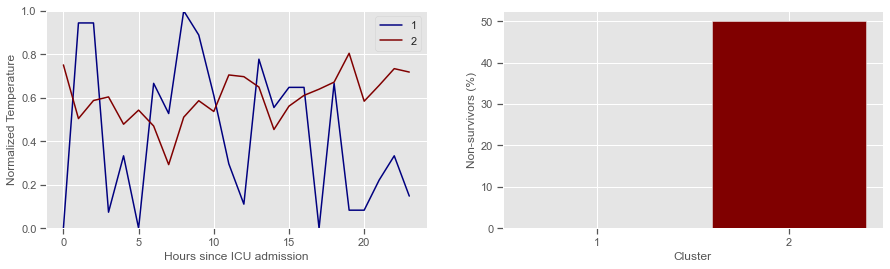

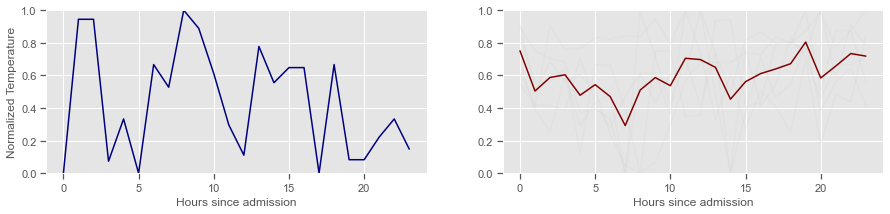

Using 7 ICU stays for creating the clusters
3 clusters
Cluster 1: 1 observations
Cluster 2: 3 observations
Cluster 3: 3 observations


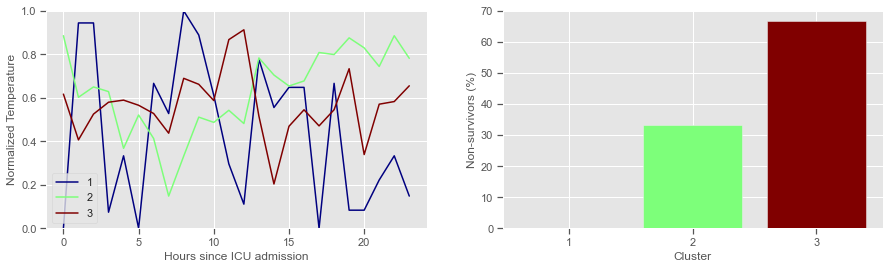

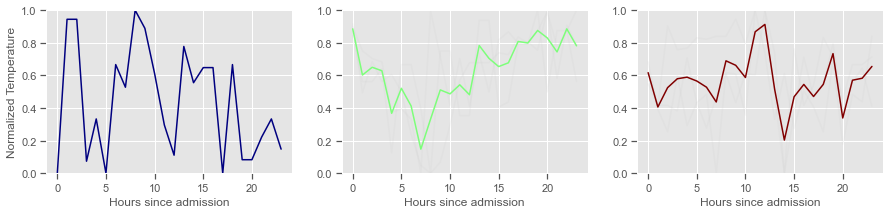

Using 7 ICU stays for creating the clusters
4 clusters
Cluster 1: 3 observations
Cluster 2: 1 observations
Cluster 3: 1 observations
Cluster 4: 2 observations


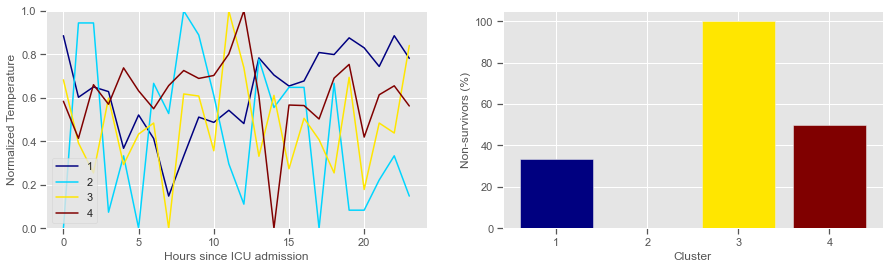

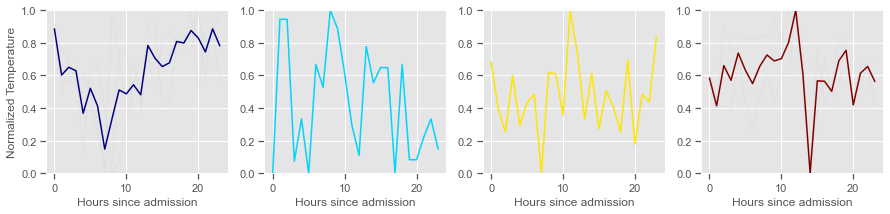

Using 7 ICU stays for creating the clusters
5 clusters
Cluster 1: 1 observations
Cluster 2: 2 observations
Cluster 3: 1 observations
Cluster 4: 1 observations
Cluster 5: 2 observations


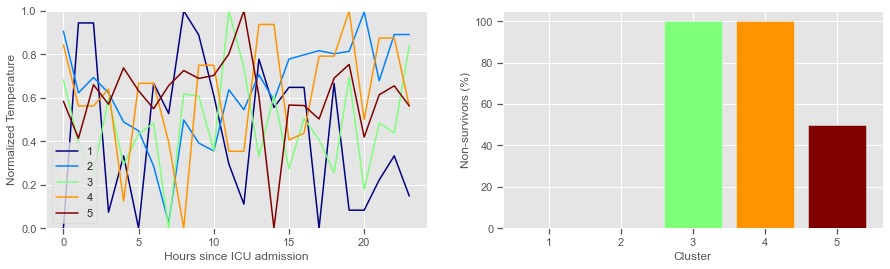

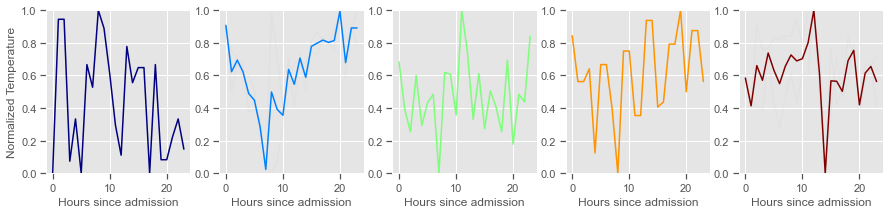

In [34]:
variable = 'Temperature'
clusters = range(2, 6)

ids_clustering = X_train.index.unique()
for K in clusters:
    data4clustering, cluster_labels = clustering(variable, ids_clustering, K)

In [35]:
Ks = dict([('HeartRate', 4), 
           ('LactateABG', 4),
           ('PaCO2', 5),
           ('P01', 5),
           ('Temperature', 4),
           ('PH', 4),
           ('SET_FIO2',4),
           ('PaO2',4)
          ])
variables=['SET_FIO2', 'P01', 'PH','PaCO2','PaO2',
       'LactateABG', 'HeartRate','Temperature']

SET_FIO2
Using 7 ICU stays for creating the clusters
Using 6 ICU stays for cluster assignment
4 clusters
Cluster 1: 1 observations
Cluster 2: 2 observations
Cluster 3: 3 observations
Cluster 4: 1 observations


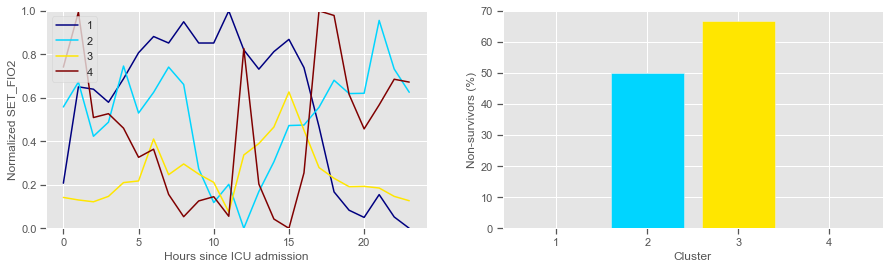

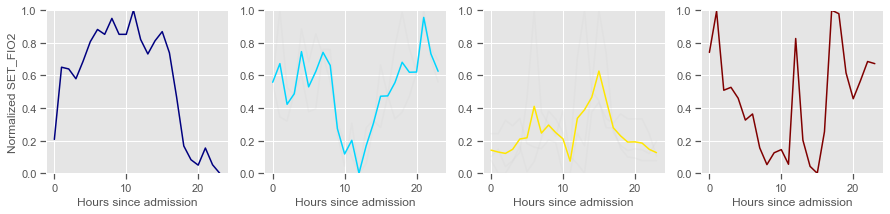

P01
Using 7 ICU stays for creating the clusters
Using 6 ICU stays for cluster assignment
5 clusters
Cluster 1: 1 observations
Cluster 2: 2 observations
Cluster 3: 1 observations
Cluster 4: 2 observations
Cluster 5: 1 observations


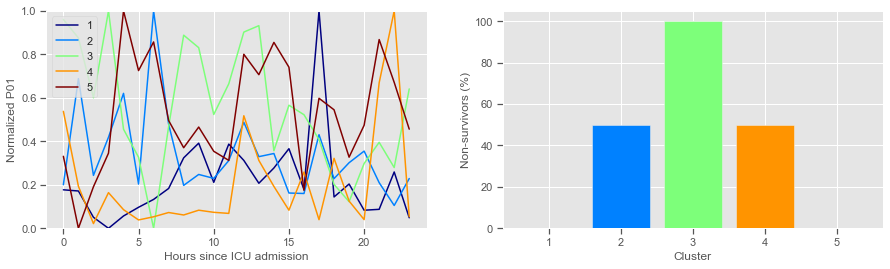

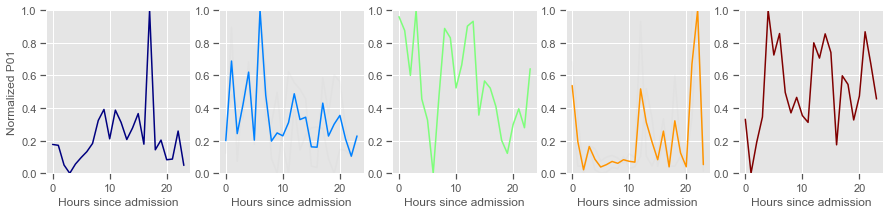

PH
Using 7 ICU stays for creating the clusters
Using 6 ICU stays for cluster assignment
4 clusters
Cluster 1: 2 observations
Cluster 2: 3 observations
Cluster 3: 1 observations
Cluster 4: 1 observations


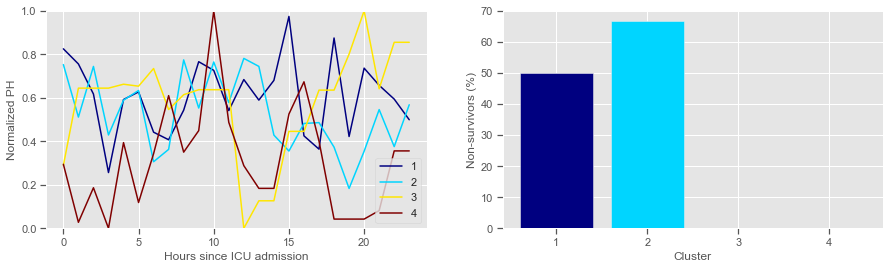

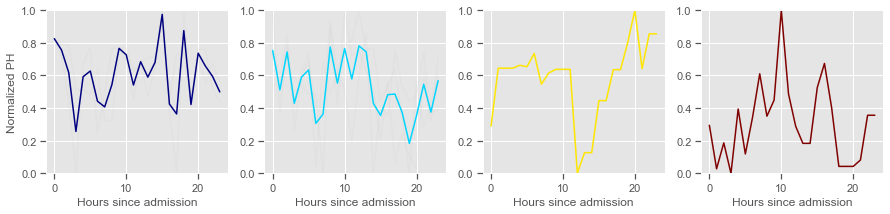

PaCO2
Using 7 ICU stays for creating the clusters
Using 6 ICU stays for cluster assignment
5 clusters
Cluster 1: 2 observations
Cluster 2: 2 observations
Cluster 3: 1 observations
Cluster 4: 1 observations
Cluster 5: 1 observations


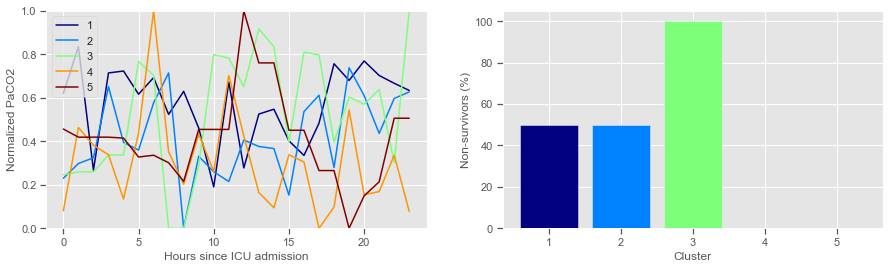

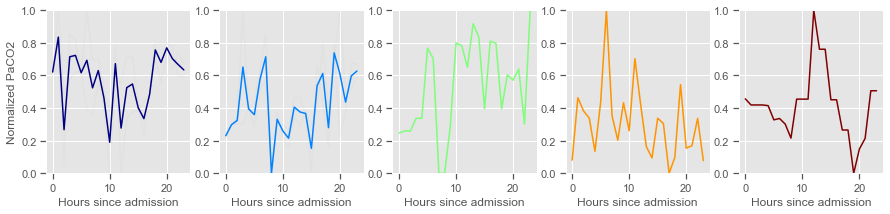

PaO2
Using 7 ICU stays for creating the clusters
Using 6 ICU stays for cluster assignment
4 clusters
Cluster 1: 2 observations
Cluster 2: 1 observations
Cluster 3: 3 observations
Cluster 4: 1 observations


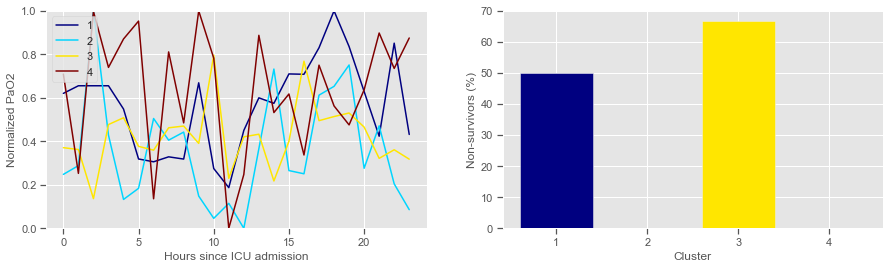

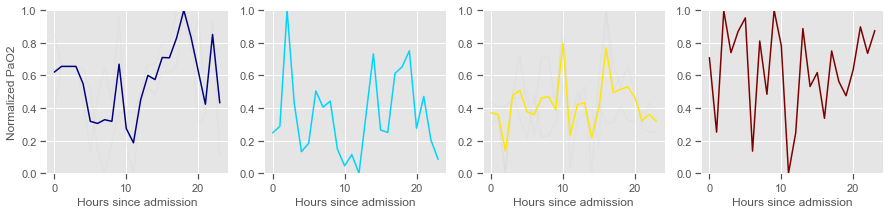

LactateABG
Using 7 ICU stays for creating the clusters
Using 6 ICU stays for cluster assignment
4 clusters
Cluster 1: 3 observations
Cluster 2: 1 observations
Cluster 3: 2 observations
Cluster 4: 1 observations


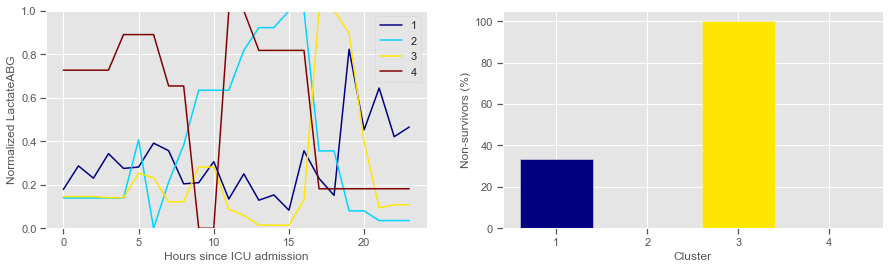

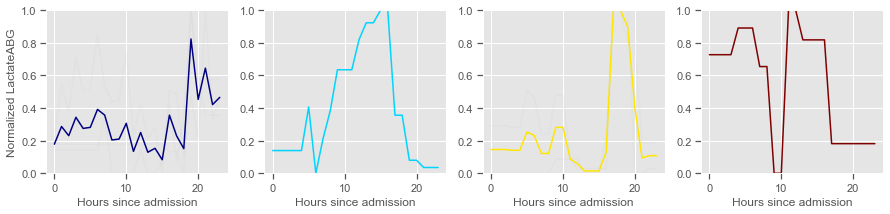

HeartRate
Using 7 ICU stays for creating the clusters
Using 6 ICU stays for cluster assignment
4 clusters
Cluster 1: 3 observations
Cluster 2: 2 observations
Cluster 3: 1 observations
Cluster 4: 1 observations


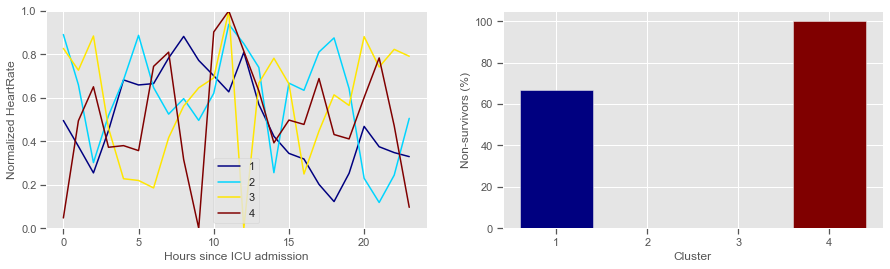

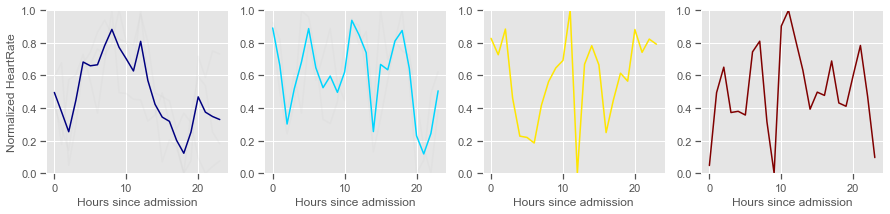

Temperature
Using 7 ICU stays for creating the clusters
Using 6 ICU stays for cluster assignment
4 clusters
Cluster 1: 3 observations
Cluster 2: 1 observations
Cluster 3: 1 observations
Cluster 4: 2 observations


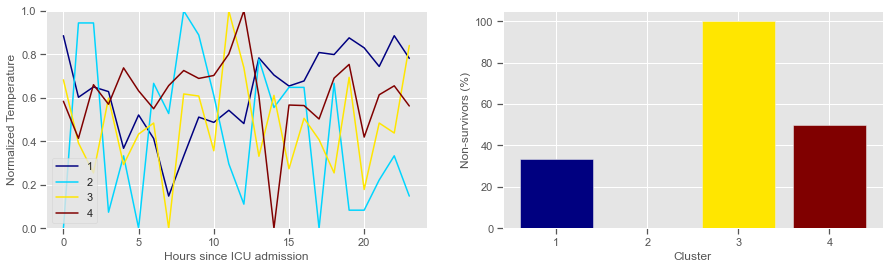

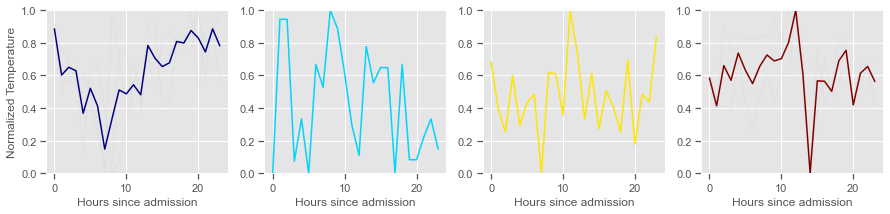

In [36]:
id_train = X_train.index.unique()
id_test = X_test.index.unique()
cluster_labels_train = pd.DataFrame()
cluster_labels_test = pd.DataFrame()

for feature in variables:
    print(feature)
    K = Ks[feature]
    data4clustering, labels_train, labels_test = clustering(feature, id_train, K, id_test)

    labels_test.columns=['CL ' + feature]
    labels_train.columns=['CL ' + feature]
    
    cluster_labels_train = pd.concat([cluster_labels_train, labels_train], axis=1).dropna(axis=0)
    cluster_labels_test = pd.concat([cluster_labels_test, labels_test], axis=1).dropna(axis=0)


for col in cluster_labels_train:
    cluster_labels_train[col] = cluster_labels_train[col].astype('category')

for col in cluster_labels_test:
    cluster_labels_test[col] = cluster_labels_test[col].astype('category')